This notebook demonstrates how to approach this competition using sentence classification. Each discourse is split into sentences to train an SVM model that will predict on individual sentences in the testing data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df = pd.read_csv("/kaggle/input/feedback-prize-2021/train.csv")

<AxesSubplot:>

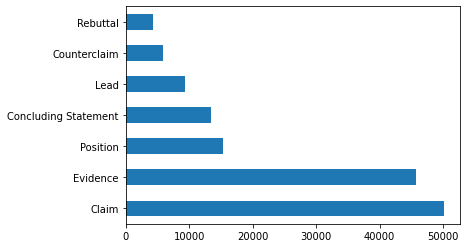

In [3]:
train_df.discourse_type.value_counts().plot.barh()

In [4]:
train_texts= list(train_df.discourse_text)

In [5]:
train_labels = np.array(train_df.discourse_type)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# https://developers.google.com/machine-learning/guides/text-classification
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.

NGRAM_RANGE = (1, 2) #Unigrams and bigrams

# Limit on the number of features. Top 20K features are used.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
TOKEN_MODE = 'word'

# Document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2


# Arguments for tf-idf vectorizer.
kwargs = {
        'ngram_range': NGRAM_RANGE,  # Use Unigrams and bigrams
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,  # Split text into word tokens.
        'min_df': MIN_DOCUMENT_FREQUENCY,
}
vectorizer = TfidfVectorizer(**kwargs)

# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(train_texts)


# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
selector.fit(x_train, train_labels)
x_train = selector.transform(x_train).astype('float32')

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [7]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()

print("training")
svm_model.fit(x_train, train_labels)

training


LinearSVC()

In [8]:
#Create dict with each testing essay's text and id
def create_test_texts_list():
    total_list = []
    
    test_dir = "../input/feedback-prize-2021/test"
    for filename in os.listdir(test_dir):
        file_path = os.path.join(test_dir, filename)
        # checking if it is a file
        if os.path.isfile(file_path) and os.path.splitext(file_path)[1] == ".txt":
            with open(file_path) as f:
                    total_list.append({
                        'text' : f.read(), 
                        'id' : os.path.splitext(filename)[0]
                    })
    
    return total_list

In [9]:
test_texts = create_test_texts_list()

In [10]:
pred_dicts_list = []

for test_text in test_texts:
    
    total_word_count = 0
    
    tokenized_sentences = nltk.sent_tokenize(test_text["text"])
    
    x_test = vectorizer.transform(tokenized_sentences)
    x_test = selector.transform(x_test).astype('float32')
    preds = svm_model.predict(x_test) #Returns list
    
    
    for i, pred in enumerate(preds):
        
        # Generate prediction strings for each predicted discourse
        tokenized_sentence = tokenized_sentences[i]
        
        if i == 0 or preds[i-1] != pred:
            prediction_string = ""
        
        for x in range(total_word_count, total_word_count + len(tokenized_sentence.split())):
            prediction_string += f"{x} "
        
        total_word_count += len(tokenized_sentence.split())
        
        try:
            if preds[i+1] == pred:
                continue
        except:
            pass
        
        pred_dicts_list.append({
            "id" : test_text["id"],
            "class" : pred, 
            "predictionstring" : prediction_string.strip()
        })

In [11]:
submission_df = pd.DataFrame(pred_dicts_list)

In [12]:
submission_df.to_csv("submission.csv", index=False)